# Config

In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
import conceptlab as clab
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import anndata as ad
import scanpy as sc
import torch
import scipy.spatial
import matplotlib.patches as mpatches
import string

from omegaconf import OmegaConf
import pytorch_lightning as pl

In [17]:
DATA_PATH = '/braid/havivd/scgen/kang.h5ad'
MODEL_PATH = '/braid/havivd/scgen/kang_model_params.pth'
USE_SAVED_MODEL = False
OVERWRITE_SAVED_MODEL = False
USE_PC = True
Z_SCORE = False
CONCEPT_KEY = 'concepts'
RANDOM_SEED = 0

# Set random seeds for reproducibility
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [18]:
# --- Plotting Configuration ---
CT_CMAP = {
    'B cells': "#e91111", 'CD4 T cells': '#048757', 'CD8 T cells': '#9cdb97',
    'CD14+ Monocytes': '#90e0ef', 'Dendritic cells': '#ffb72a',
    'FCGR3A+ Monocytes': '#b18bda', 'Megakaryocytes': '#c5c5b6', 'NK cells': '#51696c'
}
STIM_CMAP = {'ctrl': '#fcb6b1', 'stim': '#c44536'}
# IDENT_CMAP = {
#     'train': '#676765', 'held out for intervention': '#c84639',
#     'held out as GT': '#048757', 'intervened on': '#06d400'
# }

IDENT_CMAP = {
    'train': '#676765', 'intervention': '#c84639','held out for intervention': '#c84639',
    'held out as GT': '#048757', 'intervened on': '#06d400'
}

TITLE_MAP = {'cell': 'Cell Type', 'stim': 'State', 'ident': 'Split'}

# DATA LOADING AND PREPARATION

In [19]:
# def split_data_for_counterfactuals(adata, hold_out_label, mod_label, p_intervention=0.2):
#     """Splits data into train, intervention, and ground truth sets."""
#     print("Splitting data for counterfactual experiment...")
#     labels = adata.obs['cell_stim']
#     is_test = (labels == hold_out_label)
#     is_inter_pool = (labels == mod_label)

#     # Create a random mask to select a subset for intervention
#     inter_mask = np.random.binomial(1, p=p_intervention, size=is_inter_pool.sum()).astype(bool)
#     is_inter = np.zeros_like(labels, dtype=bool)
#     is_inter[is_inter_pool] = inter_mask
    
#     is_train = ~is_test & ~is_inter

#     # Create AnnData objects for each split
#     adata_train = adata[is_train].copy()
#     adata_test = adata[is_test].copy()
#     adata_inter = adata[is_inter].copy()

#     # Store split identifiers in the original object for later merging
#     ident_vec = np.array(['train'] * len(adata)).astype('<U32')
#     ident_vec[is_test] = 'held out as GT'
#     ident_vec[is_inter] = 'held out for intervention'
#     adata.obs['ident'] = ident_vec
    
#     print(f"Train set: {len(adata_train)} cells")
#     print(f"Intervention set: {len(adata_inter)} cells")
#     print(f"Ground Truth set: {len(adata_test)} cells")

#     return adata, adata_train, adata_test, adata_inter


def split_data(adata, hold_out_label, mod_label):
    """
    Splits data into train, intervention, and ground truth sets.

    - Ground Truth: All cells with the `hold_out_label`.
    - Intervention: All cells with the `mod_label`.
    - Train: All remaining cells.
    """
    print("Splitting data with simplified logic...")
    labels = adata.obs['cell_stim']

    # Define the three disjoint sets based on their labels
    is_test = (labels == hold_out_label)
    is_inter = (labels == mod_label)
    is_train = ~is_test

    # Create AnnData objects for each split
    adata_train = adata[is_train].copy()
    adata_test = adata[is_test].copy()
    adata_inter = adata[is_inter].copy()

    # Store split identifiers in the original object
    ident_vec = np.array(['train'] * len(adata)).astype('<U32')
    ident_vec[is_test] = 'held out as GT'
    ident_vec[is_inter] = 'intervention'
    adata.obs['ident'] = ident_vec
    
    print(f"Train set: {len(adata_train)} cells")
    print(f"Intervention set: {len(adata_inter)} cells")
    print(f"Ground Truth set: {len(adata_test)} cells")

    return adata, adata_train, adata_test, adata_inter



# MODELING & PREDICTION METHODS

## Method 1: scCBGM

In [20]:


def train_method_1_cbgm(adata_train, pc = USE_PC):
    """Trains and returns the scCBGM model."""
    print("Training scCBGM model...")

    # --- MODIFICATION START ---
    # Conditionally set the data source and input dimension based on the 'pca' flag
    if pc:
        # Use PCA data from the .obsm attribute
        obsm_key_to_use = 'X_pca'
        input_dimension = adata_train.obsm[obsm_key_to_use].shape[1]
        print(f"Using PCA data from .obsm['{obsm_key_to_use}'] with {input_dimension} dimensions.")
    else:
        # Use the default gene expression matrix (.X)
        obsm_key_to_use = None
        input_dimension = adata_train.shape[1]
        print(f"Using gene expression data from .X with {input_dimension} dimensions.")
    # --- MODIFICATION END ---

    config = OmegaConf.create(dict(
        has_cbm=True, lr=5e-4, hidden_dim=256, beta=1e-5,
        input_dim=input_dimension,  # <-- Use the dynamically set input dimension
        latent_dim=128,
        n_concepts=adata_train.obsm[CONCEPT_KEY].shape[1],
        min_bottleneck_size=128, independent_training=True,
        concepts_hp=0.005, orthogonality_hp=0.2, use_soft_concepts=False
    ))
    model = clab.models.scCBGM(config)

    data_module = clab.data.dataloader.GeneExpressionDataModule(
        adata_train,
        obsm_key=obsm_key_to_use,  # <-- Pass the selected obsm_key to the data module
        add_concepts=True,
        concept_key=CONCEPT_KEY,
        batch_size=128,
        normalize=False
    )
    trainer = pl.Trainer(max_epochs=1000, log_every_n_steps=10, accelerator='auto')
    trainer.fit(model, data_module)

    return model.to("cpu").eval()

def predict_with_method_1_cbgm(model, adata_inter, hold_out_label, pc = USE_PC):
    """Performs intervention using a trained scCBGM model."""
    print("Performing intervention with scCBGM...")
    if(pc):
        x_intervene_on =  torch.tensor(adata_inter.obsm['X_pca'], dtype=torch.float32)
    else:
        x_intervene_on = torch.tensor(adata_inter.X, dtype=torch.float32)
    c_intervene_on = adata_inter.obsm[CONCEPT_KEY].to_numpy().astype(np.float32)

    # Define the intervention by creating a mask and new concept values
    mask = torch.zeros(c_intervene_on.shape, dtype=torch.float32)
    mask[:, -1] = 1  # Intervene on the last concept (stim)
    
    inter_concepts = torch.tensor(c_intervene_on, dtype=torch.float32)
    inter_concepts[:, -1] = 1 # Set stim concept to 1

    with torch.no_grad():
        inter_preds = model.intervene(x_intervene_on, mask=mask, concepts=inter_concepts)
    
    inter_preds = inter_preds['x_pred'].cpu().numpy()
    
    if(pc):
        x_inter_preds = adata_inter.uns['pc_transform'].inverse_transform(inter_preds)
    else:
        x_inter_preds = inter_preds

    pred_adata = ad.AnnData(x_inter_preds, var=adata_inter.var)
    pred_adata.obs['ident'] = 'intervened on'
    pred_adata.obs['cell_stim'] = hold_out_label + '*'

    if(pc):
        pred_adata.obsm['X_pca'] = inter_preds
    return pred_adata


##  Method 2: Flow Matching with Learned Concepts

In [ ]:
def get_learned_concepts(scCBGM_model, adata_full, pc = USE_PC):
    """Uses a trained scCBGM to generate learned concepts for all data."""
    print("Generating learned concepts from scCBGM...")

    if(pc):
        all_x = torch.tensor(adata_full.obsm['X_pca'], dtype=torch.float32)
    else:
        all_x = torch.tensor(adata_full.X, dtype=torch.float32)

    with torch.no_grad():
        enc = scCBGM_model.encode(all_x)
        adata_full.obsm['scCBGM_concepts_known'] = scCBGM_model.cb_concepts_layers(enc['mu']).cpu().numpy()
        adata_full.obsm['scCBGM_concepts_unknown'] = scCBGM_model.cb_unk_layers(enc['mu']).cpu().numpy()

    adata_full.obsm['scCBGM_concepts'] = np.concatenate([adata_full.obsm['scCBGM_concepts_known'], adata_full.obsm['scCBGM_concepts_unknown']], axis=1)
    return adata_full

def train_method_2_fm_learned(adata_train, pc = USE_PC, z_score = Z_SCORE):
    """Trains and returns the CB-FM model using learned concepts."""
    print("Training Conditonal Flow Model")

    if(pc):
        data_matrix = adata_train.obsm['X_pca']
    else:
        data_matrix = adata_train.X
        if(z_score):
            data_matrix = (data_matrix - adata_train.var['mean'].to_numpy()[None, :]) / adata_train.var['std'].to_numpy()[None, :]  # Z-score normalization

    config = dict(
        input_dim=data_matrix.shape[1],
        hidden_dim=1024,
        latent_dim=128,
        n_concepts=adata_train.obsm['scCBGM_concepts'].shape[1],
        n_layers=4,
        dropout=0.1,
        p_uncond = 0.1)

    fm_model = clab.models.cond_fm.Cond_FM(config=config)

    fm_model.train_loop(
        data=torch.from_numpy(data_matrix.astype(np.float32)),
        concepts=torch.from_numpy(adata_train.obsm['scCBGM_concepts'].astype(np.float32)),
        num_epochs=1000, batch_size=128, lr=3e-4,
    )
    return fm_model



def predict_with_method_2_fm_learned(model, adata_inter, hold_out_label, pc = USE_PC, z_score = Z_SCORE, ):
    """Performs intervention using a trained learned-concept CB-FM model."""
    print("Performing intervention with CB-FM (learned)...")
    c_known_inter = torch.from_numpy(adata_inter.obsm['scCBGM_concepts_known'].astype(np.float32))
    c_unknown_inter = torch.from_numpy(adata_inter.obsm['scCBGM_concepts_unknown'].astype(np.float32))
    
    inter_concepts_known = c_known_inter.clone()
    inter_concepts_known[:, -1] = 1 # Set stim concept to 1
    
    if(pc):
        x_inter = adata_inter.obsm['X_pca']
    else:
        x_inter = adata_inter.X
        if(z_score):
            x_inter = (x_inter - adata_inter.var['mean'].to_numpy()[None, :]) / adata_inter.var['std'].to_numpy()[None, :]

    init_concepts = np.concatenate([c_known_inter, c_unknown_inter], axis=1)
    edit_concepts = np.concatenate([inter_concepts_known, c_unknown_inter], axis=1)

    inter_preds = model.edit(
             x = torch.from_numpy(x_inter.astype(np.float32)).to('cuda'),
             c = torch.from_numpy(init_concepts.astype(np.float32)).to('cuda'),
             c_prime = torch.from_numpy(edit_concepts.astype(np.float32)).to('cuda'),
             t_edit = 0.0,
             n_steps = 1000,
             w_cfg_forward = 1.0,
             w_cfg_backward = 1.0,
             noise_add = 0.0)
    
    inter_preds = inter_preds.detach().cpu().numpy()

    if(pc):
        x_inter_preds = adata_inter.uns['pc_transform'].inverse_transform(inter_preds)
    else:
        x_inter_preds = inter_preds

    if(z_score):
        x_inter_preds = (x_inter_preds * adata_inter.var['std'].to_numpy()[None, :]) + adata_inter.var['mean'].to_numpy()[None, :]

    pred_adata = ad.AnnData(x_inter_preds, var=adata_inter.var)
    pred_adata.obs['ident'] = 'intervened on'
    pred_adata.obs['cell_stim'] = hold_out_label + '*'

    if(pc):
        pred_adata.obsm['X_pca'] = inter_preds

    return pred_adata




## Method 3: Concept Flows



In [22]:
def train_method_3_concept_flows(adata_train, pc = USE_PC, z_score = Z_SCORE):
    """Trains and returns the CB-FM model using learned concepts."""
    print("Training Concept Flow Model")

    if(pc):
        data_matrix = adata_train.obsm['X_pca']
    else:
        data_matrix = adata_train.X
        if(z_score):
            data_matrix = (data_matrix - adata_train.var['mean'].to_numpy()[None, :]) / adata_train.var['std'].to_numpy()[None, :]  # Z-score normalization
            
    config = dict(
        input_dim=data_matrix.shape[1],
        hidden_dim=1024,
        latent_dim=128,
        n_concepts=adata_train.obsm[CONCEPT_KEY].to_numpy().shape[1],
        n_unkown = 128,
        n_layers=4,
        dropout=0.1,
        p_uncond=0.1)

    fm_model = clab.models.concept_fm.Concept_FM(config=config)

    fm_model.train_loop(
        data=torch.from_numpy(data_matrix.astype(np.float32)),
        concepts=torch.from_numpy(adata_train.obsm[CONCEPT_KEY].to_numpy().astype(np.float32)),
        num_epochs=1000, batch_size=128, lr=3e-4,
    )
    return fm_model

def predict_with_method_3_concept_flows(model, adata_inter, hold_out_label, pc = USE_PC, z_score = Z_SCORE):
    """Performs intervention using a trained scCBGM model."""
    print("Performing intervention with concept flow...")


    if(pc):
        data_matrix = adata_inter.obsm['X_pca']
    else:
        data_matrix = adata_inter.X
        if(z_score):
            data_matrix = (data_matrix - adata_inter.var['mean'].to_numpy()[None, :]) / adata_inter.var['std'].to_numpy()[None, :]  # Z-score normalization

    x_intervene_on = torch.from_numpy(data_matrix)
    c_intervene_on = torch.from_numpy(adata_inter.obsm[CONCEPT_KEY].to_numpy().astype(np.float32))

    
    inter_concepts_known = c_intervene_on.clone()
    inter_concepts_known[:, -1] = 1 # Set stim concept to 1
    
    # Define the intervention by creating a mask and new concept values
    mask = torch.zeros(c_intervene_on.shape, dtype=torch.float32)
    mask[:, -1] = 1  # Intervene on the last concept (stim)
    
    inter_concepts = torch.tensor(c_intervene_on, dtype=torch.float32)
    inter_concepts[:, -1] = 1 # Set stim concept to 1

    with torch.no_grad():
        inter_preds = model.intervene(x_intervene_on.to('cuda'), mask=mask.to('cuda'), concepts=inter_concepts.to('cuda'))

    inter_preds = inter_preds.detach().cpu().numpy()

    if(pc):
        x_inter_preds = adata_inter.uns['pc_transform'].inverse_transform(inter_preds)
    else:
        x_inter_preds = inter_preds

    if(z_score):
        x_inter_preds = (x_inter_preds * adata_inter.var['std'].to_numpy()[None, :]) + adata_inter.var['mean'].to_numpy()[None, :]

    pred_adata = ad.AnnData(x_inter_preds, var=adata_inter.var)
    pred_adata.obs['ident'] = 'intervened on'
    pred_adata.obs['cell_stim'] = hold_out_label + '*'

    if(pc):
        pred_adata.obsm['X_pca'] = inter_preds
    return pred_adata



## Method 4: Flow Matching with Raw Concepts 

In [23]:

def train_method_4_fm_raw(adata_train, pc = USE_PC, z_score = Z_SCORE):
    """Trains and returns the CB-FM model using learned concepts."""

    print("Training Conditonal Flow Model")

    if(pc):
        data_matrix = adata_train.obsm['X_pca']
    else:
        data_matrix = adata_train.X
        if(z_score):
            data_matrix = (data_matrix - adata_train.var['mean'].to_numpy()[None, :]) / adata_train.var['std'].to_numpy()[None, :]  # Z-score normalization

    config = dict(
        input_dim=data_matrix.shape[1],
        hidden_dim=1024,
        latent_dim=128,
        n_concepts=adata_train.obsm[CONCEPT_KEY].to_numpy().shape[1],
        n_layers=4,
        dropout=0.1)

    fm_model = clab.models.cond_fm.Cond_FM(config=config)

    fm_model.train_loop(
        data=torch.from_numpy(data_matrix.astype(np.float32)),
        concepts=torch.from_numpy(adata_train.obsm[CONCEPT_KEY].to_numpy().astype(np.float32)),
        num_epochs=1000, batch_size=128, lr=3e-4,
    )
    return fm_model

def predict_with_method_4_fm_raw(model, adata_inter, hold_out_label, pc = USE_PC, z_score = Z_SCORE):
    """Performs intervention using a trained raw-concept CB-FM model."""
    print("Performing intervention with CB-FM (raw)...")
    c_intervene_on = torch.from_numpy(adata_inter.obsm[CONCEPT_KEY].to_numpy().astype(np.float32))
    inter_concepts = c_intervene_on.clone()
    inter_concepts[:, -1] = 1 # Set stim concept to 1

    with torch.no_grad():
        inter_preds = model.decode(
            h=inter_concepts.to('cuda'),
            n_steps=1000,
        )
    inter_preds = inter_preds.detach().cpu().numpy()

    if(pc):
        x_inter_preds = adata_inter.uns['pc_transform'].inverse_transform(inter_preds)
    else:
        x_inter_preds = inter_preds

    if(z_score):
        x_inter_preds = (x_inter_preds * adata_inter.var['std'].to_numpy()[None, :]) + adata_inter.var['mean'].to_numpy()[None, :]

    pred_adata = ad.AnnData(x_inter_preds, var=adata_inter.var)
    pred_adata.obs['ident'] = 'intervened on'
    pred_adata.obs['cell_stim'] = hold_out_label + '*'

    if(pc):
        pred_adata.obsm['X_pca'] = inter_preds
    return pred_adata

# Plotting

In [24]:
def analyze_and_plot_results(adata_original, pred_adata, method_name, score):
    """Merges data, runs UMAP, calculates error, and plots the results."""
    print(f"Analyzing and plotting results for {method_name}...")
    
    # Keep only the original data splits, not the predicted one
    adata_to_merge = adata_original[adata_original.obs['ident'] != 'intervened on'].copy()

    # Merge original data with the new prediction
    adata_merged = ad.concat([adata_to_merge, pred_adata], join='inner', merge='unique')
    
    # Add other metadata for coloring
    adata_merged.obs['cell'] = [label.split('_')[0] for label in adata_merged.obs['cell_stim']]
    adata_merged.obs['stim'] = ['stim' if 'stim' in label else 'ctrl' for label in adata_merged.obs['cell_stim']]

    # Dimensionality Reduction for visualization
    #sc.pp.pca(adata_merged)
    
    #adata_merged.obsm['X_pca'] = adata_merged.X
    # check if obsm has X_pca:

    if 'X_pca' in adata_merged.obsm:
        print("using pca already computed")
    else:
        print("computing pca")
        sc.pp.pca(adata_merged)
    

    sc.pp.neighbors(adata_merged)
    sc.tl.umap(adata_merged, random_state=RANDOM_SEED)

    # # Set plotting order
    # adata_merged.obs['ident'] = pd.Categorical(adata_merged.obs['ident'],
    #     categories=['train', 'intervention', 'held out as GT', 'intervened on'])

    adata_merged.obs['ident'] = pd.Categorical(adata_merged.obs['ident'],
    categories=['train', 'intervention', 'held out for intervention', 'held out as GT', 'intervened on'])
    
    # --- Plotting ---
    fig, axes = plt.subplots(1, 3, figsize=(21, 5), constrained_layout=True)
    fig.suptitle(f"Counterfactual Prediction Results: {method_name}", fontsize=20)
    
    cmaps = [CT_CMAP, STIM_CMAP, IDENT_CMAP]
    color_keys = ['cell', 'stim', 'ident']

    for i, (ax, cmap, key) in enumerate(zip(axes, cmaps, color_keys)):
        sc.pl.umap(adata_merged, color=key, ax=ax, show=False, palette=cmap, s=10,
                   title=f"{string.ascii_uppercase[i]}) {TITLE_MAP[key]}")
        
        # Add error to the title of the last plot
        if key == 'ident':
            ax.set_title(f"{ax.get_title()}, rMMD score {score:.2f}")

            # Add intervention arrow
            source_coords = adata_merged[adata_merged.obs['ident'] == 'intervention'].obsm['X_umap'].mean(0)
            #source_coords = adata_merged[adata_merged.obs['ident'] == 'held out for intervention'].obsm['X_umap'].mean(0)
            target_coords = adata_merged[adata_merged.obs['ident'] == 'intervened on'].obsm['X_umap'].mean(0)
            arrow = mpatches.FancyArrowPatch(
                source_coords, target_coords,
                connectionstyle="arc3,rad=0.3", arrowstyle="-|>",
                linewidth=2, linestyle='dashed', color="black", mutation_scale=20
            )
            ax.add_patch(arrow)
            
    plt.show()


# Main

## Proccesing

In [25]:
import sklearn.decomposition

In [26]:
print("Loading and preprocessing data...")
adata = ad.read_h5ad(DATA_PATH)
sc.pp.normalize_total(adata, target_sum=np.median(adata.X.toarray().sum(axis=1)))
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes = 2048, subset=True)

adata.X = adata.X.toarray()

Loading and preprocessing data...


In [27]:
hold_out_label = 'NK cells_stim'
mod_label = 'NK cells_ctrl'


adata, adata_train, adata_test, adata_inter = split_data(
    adata, hold_out_label, mod_label
)

Splitting data with simplified logic...
Train set: 23217 cells
Intervention set: 915 cells
Ground Truth set: 1047 cells


In [28]:
adata.uns['pc_transform'] = sklearn.decomposition.PCA(n_components=80).fit(adata_train.X)

for x_data in [adata, adata_train, adata_test, adata_inter]:
    x_data.uns['pc_transform'] = adata.uns['pc_transform']
    x_data.obsm['X_pca'] = x_data.uns['pc_transform'].transform(x_data.X)



## --- Method 1: scCBGM ---


In [29]:
cbgm_model = train_method_1_cbgm(adata_train.copy())


/homefs/home/havivd/miniforge3/envs/conceptlab/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /homefs/home/havivd/miniforge3/envs/conceptlab/lib/p ...
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


Training scCBGM model...
Using PCA data from .obsm['X_pca'] with 80 dimensions.
Using data from .obsm['X_pca']


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/homefs/home/havivd/miniforge3/envs/conceptlab/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA B200') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.s

Epoch 999: 100%|██████████| 146/146 [00:05<00:00, 26.28it/s, v_num=63]     

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 146/146 [00:05<00:00, 26.11it/s, v_num=63]


In [30]:
pred_adata_cbgm = predict_with_method_1_cbgm(cbgm_model, adata_inter.copy(), hold_out_label)

Performing intervention with scCBGM...


In [ ]:
score_cbfm_learned_mmd = clab.evaluation.interventions.evaluate_intervention_mmd_with_target(
    x_train=adata_train.obsm['X_pca'] if USE_PC else adata_train.X,
    x_ivn=pred_adata_cbgm.obsm['X_pca'] if USE_PC else pred_adata_cbgm.X,
    x_target=adata_test.obsm['X_pca'] if USE_PC else adata_test.X,
    labels_train=adata_train.obs['cell_stim'].values)


Analyzing and plotting results for Method 1: scCBGM...
using pca already computed


/homefs/home/havivd/miniforge3/envs/conceptlab/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


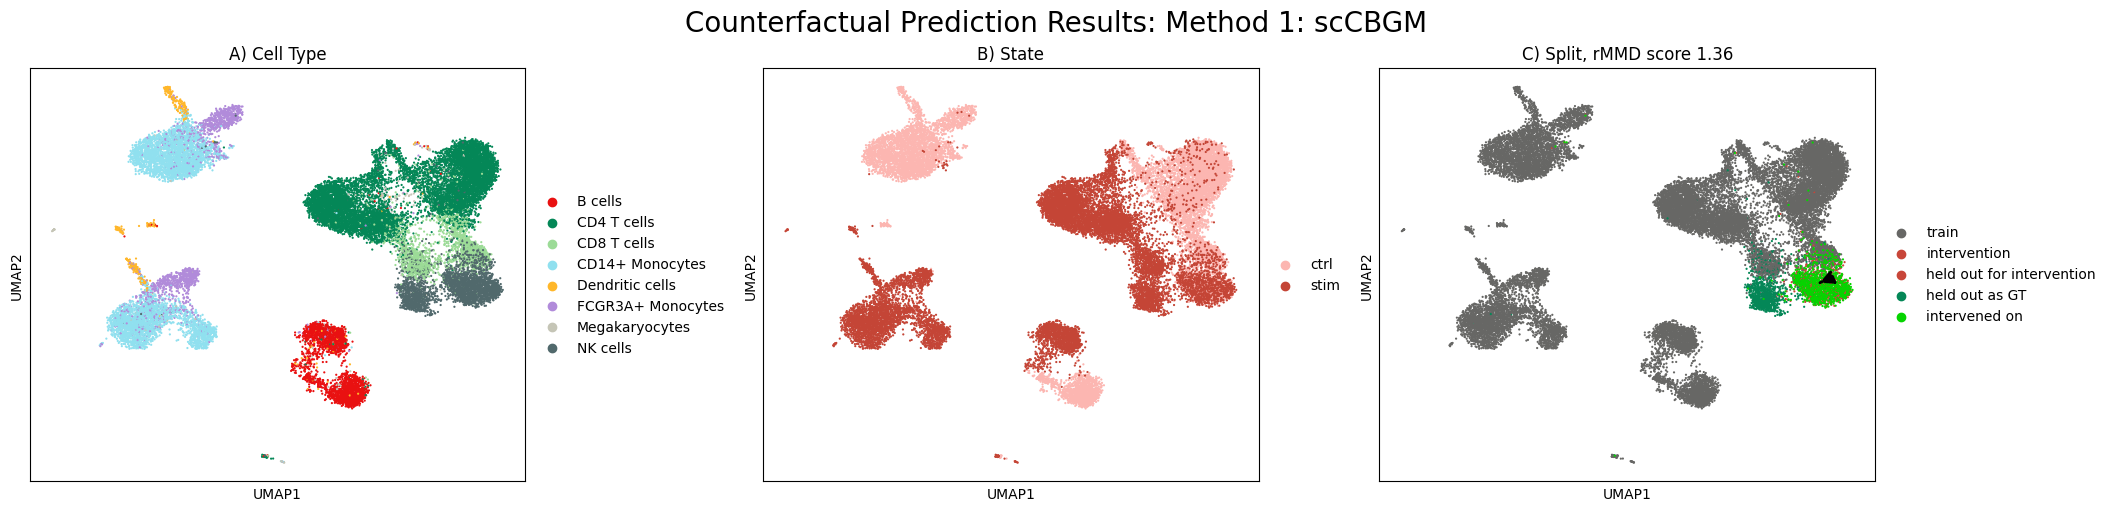

In [32]:
analyze_and_plot_results(adata, pred_adata_cbgm, "Method 1: scCBGM", score_cbfm_learned_mmd['mmd_ratio'])

## --- Method 2: CB-FM with Learned Concepts ---


In [33]:
adata_with_concepts = get_learned_concepts(cbgm_model, adata.copy())
# Distribute the newly generated concepts to the training set
adata_train.obsm['scCBGM_concepts'] = adata_with_concepts[adata_train.obs.index].obsm['scCBGM_concepts']
adata_inter.obsm['scCBGM_concepts'] = adata_with_concepts[adata_inter.obs.index].obsm['scCBGM_concepts']

adata_train.obsm['scCBGM_concepts_known'] = adata_with_concepts[adata_train.obs.index].obsm['scCBGM_concepts_known']
adata_train.obsm['scCBGM_concepts_unknown'] = adata_with_concepts[adata_train.obs.index].obsm['scCBGM_concepts_unknown']

adata_inter.obsm['scCBGM_concepts_known'] = adata_with_concepts[adata_inter.obs.index].obsm['scCBGM_concepts_known']
adata_inter.obsm['scCBGM_concepts_unknown'] = adata_with_concepts[adata_inter.obs.index].obsm['scCBGM_concepts_unknown']

Generating learned concepts from scCBGM...


In [34]:
fm_learned_model = train_method_2_fm_learned(adata_train.copy())

Training Conditonal Flow Model
Starting training on cuda for 1000 epochs...


Training Progress: 100%|██████████| 1000/1000 [08:44<00:00,  1.91it/s, avg_loss=0.0941, lr=0.000015]


In [35]:
pred_adata_fm_learned = predict_with_method_2_fm_learned(fm_learned_model, adata_inter.copy(), hold_out_label)

Performing intervention with CB-FM (learned)...
Editing from t=1.0 back to t=0.00, then forward with new condition.


In [ ]:

score_fm_learned_mmd = clab.evaluation.interventions.evaluate_intervention_mmd_with_target(
    x_train=adata_train.obsm['X_pca'] if USE_PC else adata_train.X,
    x_ivn=pred_adata_fm_learned.obsm['X_pca'] if USE_PC else pred_adata_fm_learned.X,
    x_target=adata_test.obsm['X_pca'] if USE_PC else adata_test.X,
    labels_train=adata_train.obs['cell_stim'].values,
    pre_computed_mmd_train=score_cbfm_learned_mmd['pre_computed_mmd_train']
)


In [37]:
score_fm_learned_mmd

{'mmd_ratio': np.float64(1.2469062189590587),
 'pre_computed_mmd_train': np.float64(0.6623662628019265)}

Analyzing and plotting results for Method 2: CB-FM (Learned Concepts)...
using pca already computed


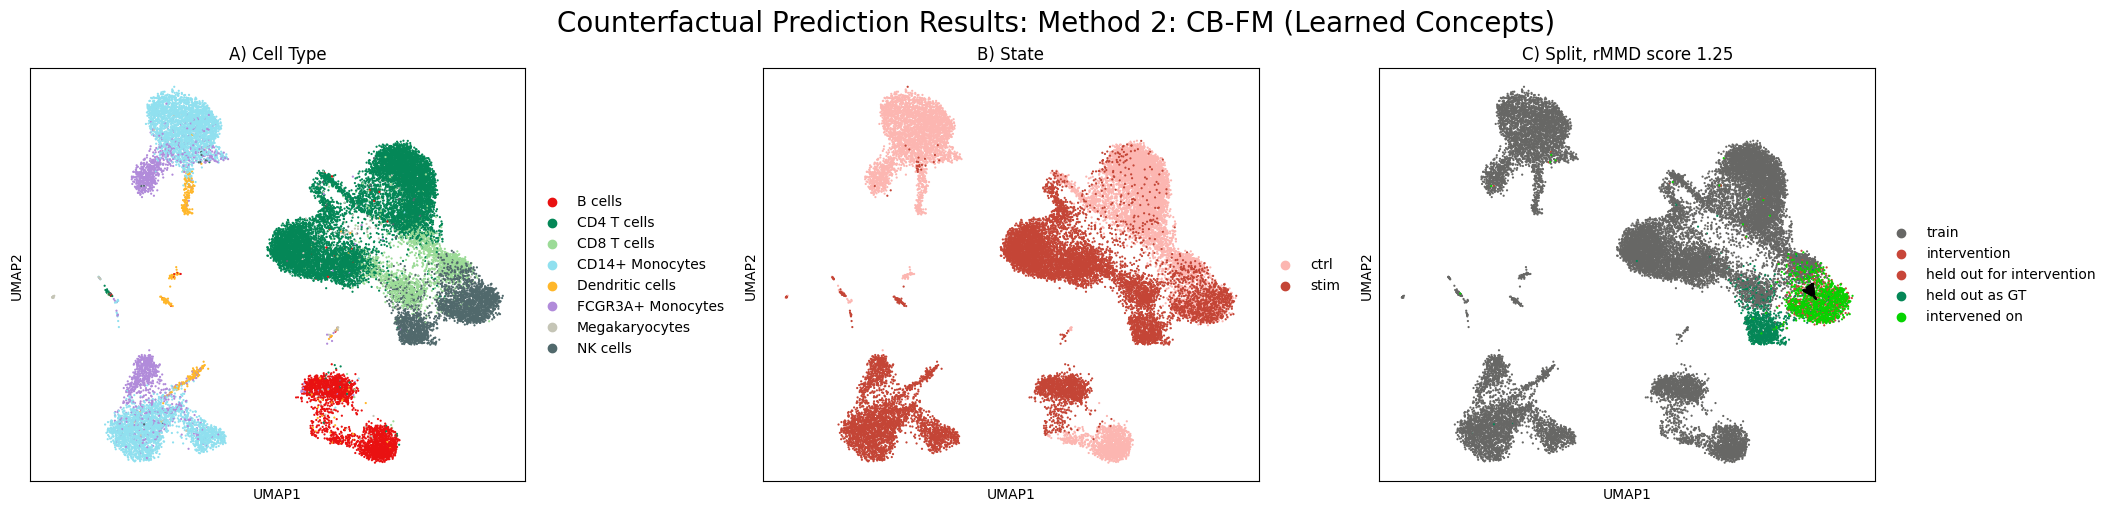

In [38]:
analyze_and_plot_results(adata, pred_adata_fm_learned, "Method 2: CB-FM (Learned Concepts)", score_fm_learned_mmd['mmd_ratio'])

## --- Method 3: Concept Flows ---

In [39]:
concept_flow_model = train_method_3_concept_flows(adata_train.copy())

Training Concept Flow Model
Starting training on cuda for 1000 epochs...


Training Progress: 100%|██████████| 1000/1000 [16:45<00:00,  1.01s/it, avg_loss=0.1476, lr=0.000015]


In [40]:
pred_adata_concept_flow = predict_with_method_3_concept_flows(concept_flow_model, adata_inter.copy(), hold_out_label)

/tmp/ipykernel_1343866/1937741563.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inter_concepts = torch.tensor(c_intervene_on, dtype=torch.float32)


Performing intervention with concept flow...
Decoding with 1000 steps and cfg_strength 1.2


In [ ]:




score_fm_cf_mmd = clab.evaluation.interventions.evaluate_intervention_mmd_with_target(
    x_train=adata_train.obsm['X_pca'] if USE_PC else adata_train.X,
    x_ivn=pred_adata_concept_flow.obsm['X_pca'] if USE_PC else pred_adata_concept_flow.X,
    x_target=adata_test.obsm['X_pca'] if USE_PC else adata_test.X,
    labels_train=adata_train.obs['cell_stim'].values,
    pre_computed_mmd_train=score_cbfm_learned_mmd['pre_computed_mmd_train']
)


Analyzing and plotting results for Method 3: Concept Flow...
using pca already computed


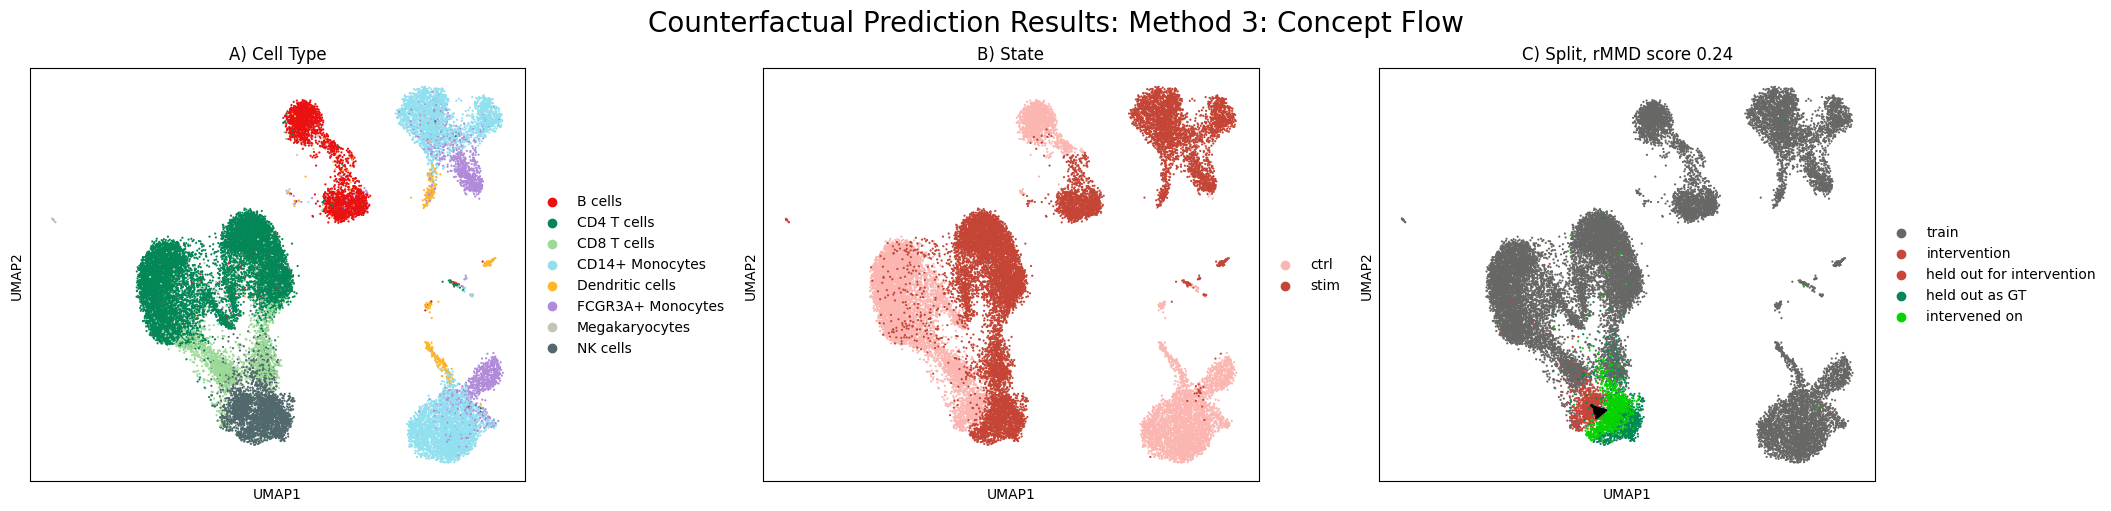

In [42]:
analyze_and_plot_results(adata, pred_adata_concept_flow, "Method 3: Concept Flow", score_fm_cf_mmd['mmd_ratio'])

## --- Method 4: CB-FM with Raw Concepts ---


In [43]:
fm_raw_model = train_method_4_fm_raw(adata_train.copy())

Training Conditonal Flow Model
Starting training on cuda for 1000 epochs...


Training Progress: 100%|██████████| 1000/1000 [08:57<00:00,  1.86it/s, avg_loss=0.5766, lr=0.000015]


In [44]:
pred_adata_fm_raw = predict_with_method_4_fm_raw(fm_raw_model, adata_inter.copy(), hold_out_label)

Performing intervention with CB-FM (raw)...
Decoding with 1000 steps and CFG scale w=1.0


In [ ]:
score_fm_raw_mmd = clab.evaluation.interventions.evaluate_intervention_mmd_with_target(
    x_train=adata_train.obsm['X_pca'] if USE_PC else adata_train.X,
    x_ivn=pred_adata_fm_raw.obsm['X_pca'] if USE_PC else pred_adata_fm_raw.X,
    x_target=adata_test.obsm['X_pca'] if USE_PC else adata_test.X,
    labels_train=adata_train.obs['cell_stim'].values,
    pre_computed_mmd_train=score_cbfm_learned_mmd['pre_computed_mmd_train']
)


Analyzing and plotting results for Method 3: CB-FM (Raw Concepts)...
using pca already computed


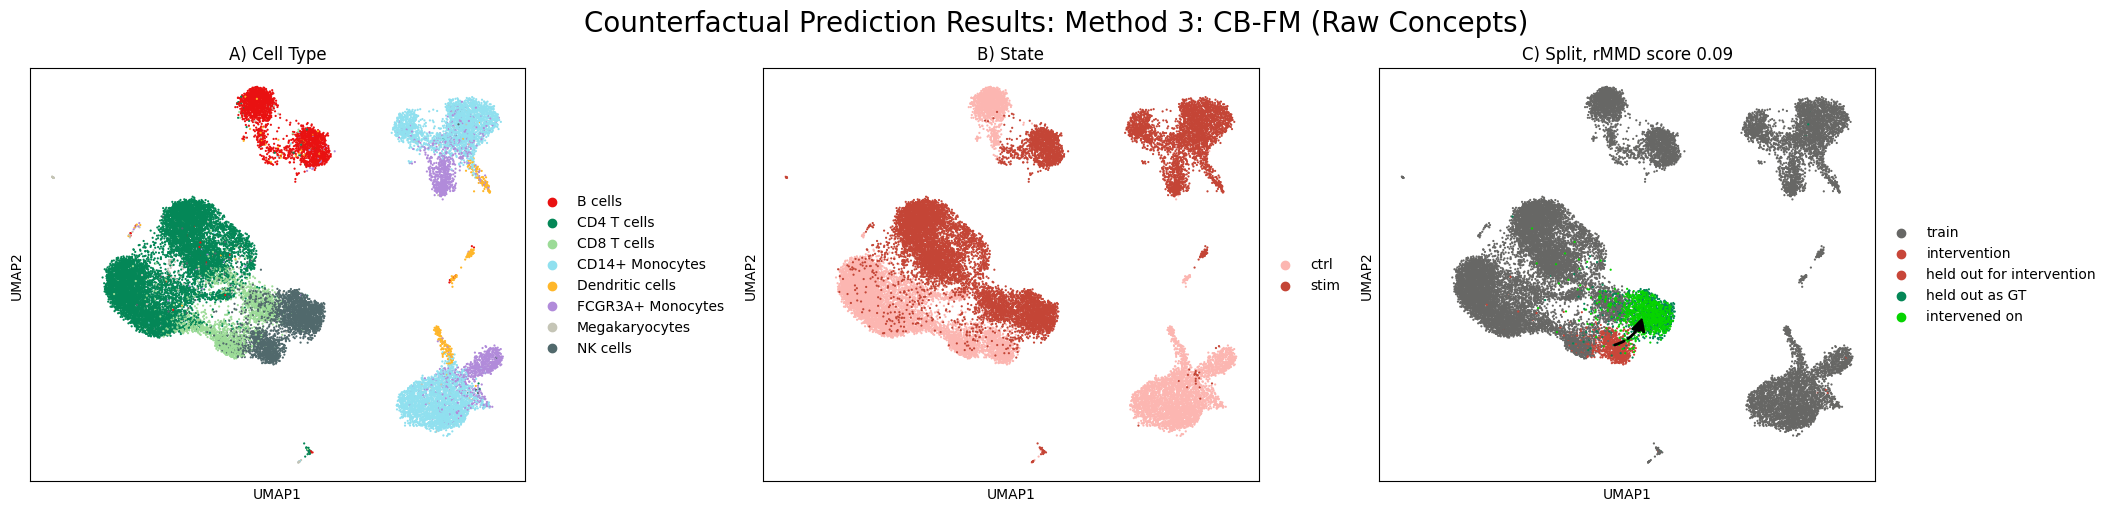

In [46]:
analyze_and_plot_results(adata, pred_adata_fm_raw, "Method 3: CB-FM (Raw Concepts)",  score_fm_raw_mmd['mmd_ratio'])